# Analyze A/B Test Results 

This project will assure you have mastered the subjects covered in the statistics lessons. We have organized the current notebook into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)

Specific programming tasks are marked with a **ToDo** tag. 

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

Each **ToDo** task below has an associated quiz present in the classroom.  Though the classroom quizzes are **not necessary** to complete the project, they help ensure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the [rubric](https://review.udacity.com/#!/rubrics/1214/view) specification. 

<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

### ToDo 1.1
Now, read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>


**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [2]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [3]:
len(df)

294478

**c.** The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

**d.** The proportion of users converted.

In [5]:
len(df.loc[df['converted'] >= 1 ]) / len(df)


0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [6]:
temp_df = df.loc[(df['group']  == "treatment") & (df['landing_page'] ==  "old_page")]
len(temp_df)

#mismatch with quiz (3893)

1965

**f.** Do any of the rows have missing values?

In [7]:
temp_df = df.isnull()
print("the following values are missing:")
temp_df.loc[(temp_df["user_id"] == True)|(temp_df["timestamp"] == True)|(temp_df["group"] == True)|(temp_df["landing_page"] == True)|(temp_df["converted"] == True)]


the following values are missing:


,user_id,timestamp,group,landing_page,converted


### ToDo 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


Use **Quiz 2** in the classroom to figure out how should we handle the rows where the group and landing_page columns don't match?

**a.** Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
##good rows:
df.loc[(df['group'] != "treatment") & (df['landing_page'] != "new_page") ]
df.loc[(df['group'] == "treatment") & (df['landing_page'] == "new_page") ]
##bad rows:
df2 = df.drop(index = df.loc[(df['group'] != "treatment") & (df['landing_page'] == "new_page") ].index)
df2 = df2.drop(index = df2.loc[(df2['group'] == "treatment") & (df2['landing_page'] != "new_page") ].index)
len(df2)

290585

In [9]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### ToDo 1.3  
Use **df2** and the cells below to answer questions for **Quiz 3** in the classroom.

**a.** How many unique **user_id**s are in **df2**?

In [10]:
df2['user_id'].nunique()


290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [11]:
temp_df2 = df2['user_id'].duplicated()
dup_index = temp_df2.loc[temp_df2 == True].index
dup_id = df2.loc[dup_index, 'user_id'].item()
dup_id

773192

**c.** Display the rows for the duplicate **user_id**? 

In [12]:
df2.loc[df2['user_id'] == dup_id]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [13]:
# Remove one of the rows with a duplicate user_id..
# Check again if the row with a duplicate user_id is deleted or not

df2 = df2.drop(dup_index)
df2.loc[df2['user_id'] == dup_id]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


### Individual apporach completing the objective

In [14]:
#x variable prefix for differentiation to rest of project
h0 = 'h0: the new page has no postiv effect'
h1 = 'h1: the new page is better than the old'
print( h0 )
print( 'h0: xconv_rate_old >= xconv_rate_new' )
print( 'h0: xconv_rate_old - xconv_rate_new >= 0' )
print("\n")
print( h1 )
print( 'h1: xconv_rate_old < xconv_rate_new' )
print( 'h1: xconv_rate_old - xconv_rate_new < 0' )
print("\n")
print("\n")
     


xdf2 = df2
xuser = len(xdf2)
xconverted = len(xdf2.loc[xdf2['converted'] == 1])
xconv_rate =  xconverted / xuser



xdf_old = xdf2.loc[xdf2['landing_page'] == "old_page"]
xuser_old = len(xdf_old)
xconverted_old = len(xdf_old.loc[xdf_old['converted'] == 1])
xconv_rate_old = xconverted_old / xuser_old



xdf_new = xdf2.loc[xdf2['landing_page'] == "new_page"]
xuser_new = len(xdf_new)
xconverted_new = len(xdf_new.loc[xdf_new['converted'] == 1])
xconv_rate_new = xconverted_new / xuser_new


xresult = xconv_rate_old - xconv_rate_new


print("useranzahl: {}".format(xuser))
print("convertierte user: {}".format(xconverted))
print("generelle convertion rate: {}".format(xconv_rate))
print("\n")

print("useranzahl old page: {}".format(xuser_old))
print("convertierte user old page: {}".format(xconverted_old))
print("convertion rate old page: {}".format(xconv_rate_old))
print("\n")

print("useranzahl new page: {}".format(xuser_new))
print("convertierte user new page: {}".format(xconverted_new))
print("convertion rate new page: {}".format(xconv_rate_new))
print("\n")

print("result von xconv_rate_old - xconv_rate_new: {}".format(xresult))
print("\n")

if xresult < 0:
    print('we do observe evidence suggesting ', h1)
    print('we do not observe evidence suggesting the null')
else:
    print('we do observe evidence suggesting ', h0)
    print('we do not observe evidence suggesting the alternative')


h0: the new page has no postiv effect
h0: xconv_rate_old >= xconv_rate_new
h0: xconv_rate_old - xconv_rate_new >= 0


h1: the new page is better than the old
h1: xconv_rate_old < xconv_rate_new
h1: xconv_rate_old - xconv_rate_new < 0




useranzahl: 290584
convertierte user: 34753
generelle convertion rate: 0.11959708724499628


useranzahl old page: 145274
convertierte user old page: 17489
convertion rate old page: 0.1203863045004612


useranzahl new page: 145310
convertierte user new page: 17264
convertion rate new page: 0.11880806551510564


result von xconv_rate_old - xconv_rate_new: 0.0015782389853555567


we do observe evidence suggesting  h0: the new page has no postiv effect
we do not observe evidence suggesting the alternative


In [15]:
# wie groß ist die wahrscheinlichkeit dass das obs zufällig eintritt?

xconv_rate - xsamplemean:  -8.1566775872e-06
xconv_rate_old - xsamplemean:  0.000781060577878
xconv_rate_new - xsamplemean:  -0.000797178407478


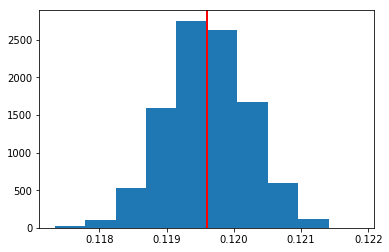

In [16]:
xconv_rate_sammler = []
for _ in range(10000):
    xsample = np.random.binomial(xuser,p=[1-xconv_rate,xconv_rate])
    xsample_cov_rate = xsample[1] / xuser
    xconv_rate_sammler.append(xsample_cov_rate)


xsamplemean = np.array(xconv_rate_sammler).mean()

plt.hist(xconv_rate_sammler);
plt.axvline(x=xsamplemean, color='g', linewidth = 2);
plt.axvline(x=xconv_rate, color='r', linewidth = 2);


print('xconv_rate - xsamplemean: ', xconv_rate - xsamplemean)
print('xconv_rate_old - xsamplemean: ', xconv_rate_old - xsamplemean)
print('xconv_rate_new - xsamplemean: ', xconv_rate_new - xsamplemean)


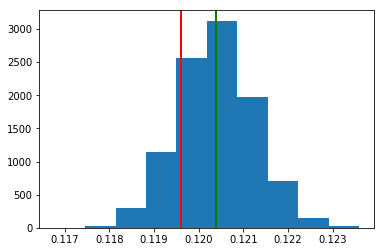

In [17]:
#bootsample old page with convertionrate old

xconv_rate_sammler_old = []
for _ in range(10000):
    xsample = np.random.binomial(xuser_old,p=[1-xconv_rate_old,xconv_rate_old])
    xsample_cov_rate = xsample[1] / xuser_old
    xconv_rate_sammler_old.append(xsample_cov_rate)


xsamplemean_old = np.array(xconv_rate_sammler_old).mean()

plt.hist(xconv_rate_sammler_old);
plt.axvline(x=xconv_rate, color='r', linewidth = 2);
plt.axvline(x=xsamplemean_old, color='g', linewidth = 2);

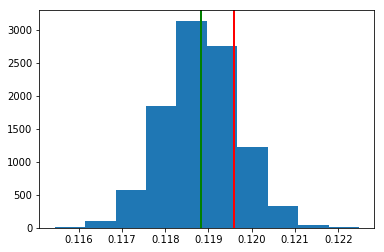

In [18]:
#bootsample new page mit convertionrate new 
xconv_rate_sammler_new = []
for _ in range(10000):
    xsample = np.random.binomial(xuser_new,p=[1-xconv_rate_new,xconv_rate_new])
    xsample_cov_rate = xsample[1] / xuser_new
    xconv_rate_sammler_new.append(xsample_cov_rate)


xsamplemean_new = np.array(xconv_rate_sammler_new).mean()

plt.hist(xconv_rate_sammler_new);
plt.axvline(x=xconv_rate, color='r', linewidth = 2);
plt.axvline(x=xsamplemean_new, color='g', linewidth = 2);


The observed convertion rate is what we would expect given our sample.

We should therefore: 
- Not Implement the new webpage.
- Keep the old webpage.
- There is no reason for running the experiment any longer.

### ToDo 1.4  
Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>





In [19]:
p_population = len(df2.loc[df2['converted'] == 1]) / len(df2)
p_population

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [20]:
p_control = len(df2.loc[(df2['converted'] == 1) & (df2['group'] == 'control')]) / len(df2.loc[(df2['group'] == 'control')])
p_control

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [21]:
p_treatment = len(df2.loc[(df2['converted'] == 1) & (df2['group'] != 'control')]) / len(df2.loc[(df2['group'] == 'treatment')])
p_treatment

0.11880806551510564

In [22]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = p_control - p_treatment
obs_diff

0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [23]:
p_new_page = len(df2.loc[(df2['landing_page'] == 'new_page')]) / len(df2)
p_new_page

0.5000619442226688

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

>**The new page (treatment group) does not lead to more convertions.** 


<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### ToDo 2.1
For now, consider you need to make the decision just based on all the data provided.  

> Recall that you just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (ToDo 1.4.c). 

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.


>***H0: p_old >= p_new***

>***H1: p_old <  p_new***


### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, you will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 



Use the cells below to provide the necessary parts of this simulation.  You can use **Quiz 5** in the classroom to make sure you are on the right track.

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [24]:
p_new = p_population
round(p_new,5)

0.1196

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [25]:
p_old = p_population
round(p_old,5)

0.1196

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>
*Hint*: The treatment group users are shown the new page.

In [26]:
n_new = len(df2.loc[(df2['group'] != 'control')])
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [27]:
n_old = len(df2.loc[(df2['group'] == 'control')])
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>

In [28]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice(2,n_new, p=[1-p_new,p_new])

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [29]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice(2,n_old, p=[ 1-p_old,p_old])

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [30]:
new_page_converted.mean() - old_page_converted.mean()

0.0011545724014111192


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [31]:
%%time
# Sampling distribution 
p_diffs = []
for _ in range(10000):
    bootsample_new_page = np.random.binomial(n_new,p=[1-p_new,p_new])
    bootsample_old_page = np.random.binomial(n_old,p=[1-p_old,p_old])
    p_diffs.append(bootsample_new_page[1]/n_new - bootsample_old_page[1]/n_new)
    
boot_mean = np.array(p_diffs).mean()
print(boot_mean)

1.92209758447e-05
CPU times: user 576 ms, sys: 3.24 ms, total: 579 ms
Wall time: 1 s


**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  

>**Tip**: Display title, x-label, and y-label in the chart.

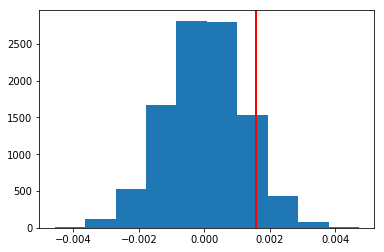

In [32]:
plt.axvline(x=obs_diff, color='r', linewidth = 2);
plt.hist(p_diffs);

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [33]:
p_diffs = np.array(p_diffs)
(p_diffs < obs_diff).mean()

0.90400000000000003

**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 

>**Put your answer here.**
the difference we observe in our original ab test data (red) is part of the distributin we genereated in order to see what a distibuton would look like if h0 were true. So the propabilty the the observed data is not due to signifcants but due to randomness is around 10% s ++

we therefore fail to reject the 0 Hypothesesis



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [34]:
df2.head(10)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [35]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = len(df2.loc[(df2['landing_page'] == 'old_page') & (df2['converted'] == 1)])
print(convert_old)
# number of conversions with the new_page
convert_new = len(df2.loc[(df2['landing_page'] != 'old_page') & (df2['converted'] == 1)])
print(convert_new)
# number of individuals who were shown the old_page
n_old = len(df2.loc[(df2['landing_page'] == 'old_page')])
print(n_old)
# number of individuals who received new_page
n_new = len(df2.loc[(df2['landing_page'] != 'old_page')])
print(n_new)

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


17489
17264
145274
145310


**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
>**Hint**: <br>
It's a two-tailed if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if you defined $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. We determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. In other words, a "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.

>Hint:<br>
For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 




Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org

---

>**Tip**: You don't have to dive deeper into z-test for this exercise. **Try having an overview of what does z-score signify in general.** 

In [36]:
count_array = np.array([convert_old, convert_new])
nobs_array = np.array([n_old, n_new])
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old],alternative='larger')
print(z_score, p_value)

-1.31092419842 0.905058312759


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>


>**the p-value is similar to the one computed earlier. We fail to reject the null hypothesis**

<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

>**a Logistic Regression**

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [37]:
df2['intercept'] = 1
df2[['x','ab_page']] = pd.get_dummies(df['group'])
df2 = df2.drop(columns=['x'])

df2.head(5)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [38]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [39]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-02-23 19:25 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

**Hints**: 
- What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**? 
- You may comment on if these hypothesis (Part II vs. Part III) are one-sided or two-sided. 
- You may also compare the current p-value with the Type I error rate (0.05).


>**They are the same.**

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>**Adding more variables gives a clearer picture about other inflential factors. It also decreases clarity of impact from other variables. Also multicollinearity can happen.**

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 
>**Hint:** Use `pandas.get_dummies()` to create dummy variables. **You will utilize two columns for the three dummy variables.** 

 Provide the statistical output as well as a written response to answer this question.

In [40]:
# Read the countries.csv
df_countires = pd.read_csv("countries.csv")
df_countires = df_countires.drop(columns=['user_id'])
df_countires.head()

,country
0,UK
1,US
2,UK
3,UK
4,UK


In [41]:
# Join with the df2 dataframe
df2 = df2.join(df_countires)
df2.head(5)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,UK
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,UK
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,UK
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,UK


In [42]:
# Create the necessary dummy variables
df2[['CA','UK', 'US']] = pd.get_dummies(df2['country'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,UK,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,UK,0,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,UK,0,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,UK,0,1,0


In [46]:
# Fit your model, and summarize the results
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'UK', 'US']])
result = logit_mod.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366119
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-02-23 19:30 AIC:              212782.7363
No. Observations:   290584           BIC:              212814.4753
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0197    0.0231  -87.5238  0.0000  -2.0650  -1.9745
UK             0.0297    0.0258    1.1514  0.2496  -0.0208   0.0802
US             0.0234    0.0241    0.9716  0.3312  -0.0238   0.0706
==================================================================

"""

In [49]:
np.exp(0.0297), np.exp(0.0234)

(1.0301454439591482, 1.0236759280352754)

>**We can predict that the convertion rate increaces by 0.3% for every page visitor from the UK and 0.24% for every page visitor from the US.**

**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 

>**Tip**: Conclusions should include both statistical reasoning, and practical reasoning for the situation. 

>**Hints**: 
- Look at all of p-values in the summary, and compare against the Type I error rate (0.05). 
- Can you reject/fail to reject the null hypotheses (regression model)?
- Comment on the effect of page and country to predict the conversion.


In [50]:
df2['ab_UK'] = df2['ab_page'] * df2['UK']
df2['ab_CA'] = df2['ab_page'] * df2['CA']

In [52]:
np.exp(0.0008), np.exp(0.0041)

(1.0008003200853504, 1.0041084164986169)

In [56]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page','UK','CA','ab_UK', 'ab_CA']])
result = logit_mod.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-02-23 19:41 AIC:              212784.6547
No. Observations:   290584           BIC:              212848.1326
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9859    0.0096  -206.7920  0.0000  -2.0047  -1.9670
ab_page      -0.0215    0.0136    -1.5817  0.1137  -0.0482   0.0052
UK            0.0013    0.0188     0.0669  0.9467  -0.0356   0.0381
CA           -0.0675    0.0385    -1.7528  0.0796  -0.1430   0.0080
ab_UK         0.0105    0.0267     0.3937  0.6938  -0.0419   0.0629
ab_CA         0.0825    0.0538     1.5339  0.1251  -0.0229   0.1880
==================================================================

"""

In [58]:
np.exp(-0.0215), np.exp(0.0013), np.exp(-0.0675), np.exp(0.0105), np.exp(0.0825)

(0.97872947746914762,
 1.0013008453662857,
 0.93472772061602749,
 1.0105553184450264,
 1.0859986734390565)

## Conclution:
>**We observe a slight underperformance of the new designed page compared to the old page. Our Test show that this underperformance is very unlikely due to a statistical abnormaly but rather expected. We fail to reject the Null Hypothesis and it is therefore in our best intrest to keep the old page. Further testing is not required**

<a id='finalcheck'></a>
## Final Check!

Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!



<a id='submission'></a>
## Submission
You may either submit your notebook through the "SUBMIT PROJECT" button at the bottom of this workspace, or you may work from your local machine and submit on  the last page of this project lesson.  

1. Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).


2. Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.


3. Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [45]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

1